<br>
<font color='black' size=6> <b>Проект для «Викишоп»</b></font>
<br><br>
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

___
<a id="start"></a><br>
<font color='black' size=6> <b> Содержание</b></font><br><br>


<font color='black' size=5> <b>1. Подготовка данных</b></font><br>


   * <a href='#step_1'> Загружаем библиотеки </a>
   * <a href='#step_1.1'> Откроем файл и изучим его </a>
          - Путь к файлу: (/datasets/toxic_comments.csv)
   * <a href='#step_1.2'> Лемматизируем текст и избавим его от лишних символов </a>
       * <a href='#step_1.2.1'>Загрузим библиотеку для обработи текста </a>
       * <a href='#step_1.2.2'> Создадим функцию по очистке данных</a>
       * <a href='#step_1.2.3'> Создадим функцию которая будет использовать функцию по очистке слов и лемматизировать каждое слово</a>
   * <a href='#step_1.3'> Посмотрим на распределение классов в данных</a>
   * <a href='#step_1.4'> Разделим выборки</a>
      * <a href='#step_1.4.1'> Проверим распределение класов в *тренировочной* выборке</a>
      * <a href='#step_1.4.2'> Проверим распределение класов в *тестовой* выборке</a>
      * <a href='#step_1.4.3'> Создадим функцию, для увеличения выборки по первому [1] классу данных и уменьшению выборки по нулевому [0] классу</a>
   * <a href='#step_1.5'> Используем технологию TF-IDF для обработки наших данны, а так же отфильтруем содержимое при помощи библиотеки `nltk`</a>
   * <a href='#step_1.end'> Вывод </a><br><br>

<font color='black' size=5> <b>2. Обучение</b></font><br>

   * <a href='#step_2'> Создадим функцию для вывода графика плотности распределения предсказанных и истинных значений </a>
   * <a href='#step_2.1'> Создадим функцию для вывода матрицы предсказаний</a>
   * <a href='#step_2.2'> Обучим модель `DecisionTreeClassifier`</a>
   * <a href='#step_2.3'> Обучим модель `LogisticRegression`</a>
   * <a href='#step_2.4'> Обучим модель `RandomForestClassifier`</a>
   * <a href='#step_2.5'> Определим порог классификации для наилучшей модели `LogisticRegression`</a>
   * <a href='#step_2.6'> Проверим выбранный порог для нашей модели</a>
   * <a href='#step_2.7'> Вычислим ROC-AUC для наилучшей модели </a>
  
   * <a href='#step_2.end'> Вывод </a> <br><br>  
      

<font color='black' size=5> <b>3. Общий вывод</b></font><br>


   * <a href='#step_3.end'> Вывод </a>
<br><br>
<font color='orange'><u>INFO</u>:<font color='gray'> При запуске ячеек, запустить <font color='green'><b><i>"Restart & Run All"

----
----

<a id="step_1"></a>
<font color='black' size=4,5> <b> Загружаем библиотеки</b></font>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
import time
from sklearn.feature_extraction.text import CountVectorizer 
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from pymystem3 import Mystem
import re 
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

<a id="step_1.1"></a>
# Подготовка

In [ ]:
data=pd.read_csv('/datasets/toxic_comments.csv')


## Посмотрим на размер таблицы и информацию о данных

In [ ]:
data.shape

(159571, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<a id="step_1.2"></a>
## Лемматизируем текст и избавим его от лишних символов

### Создадим корпус слов

In [ ]:
corpus = list(data['text'])

<a id="step_1.2.1"></a>
### Загрузим библиотеку для обработи текста

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

<a id="step_1.2.2"></a>
### Создадим функцию по очистке данных

In [ ]:
def clear_text(text):
    y=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k=" ".join(y.split())
    return k

<a id="step_1.2.3"></a>
### Создадим функцию которая будет использовать функцию по очистке слов и лемматизировать каждое слово

In [ ]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

##### Проверим работу функции

In [ ]:
test = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(test)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


##### Запустим преобразование текста

In [ ]:
%%time
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 

lemy=[]
for i in tqdm(range(len(corpus))):
    
    lemy.append(lemmafunction(clear_text(corpus[i])))
data['lemm_text']=pd.Series(lemy, index=data.index)


CPU times: user 32min 23s, sys: 2min 48s, total: 35min 11s
Wall time: 36min 24s


##### Проверим результат

In [ ]:
data['text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [ ]:
data['lemm_text'][3]

"More I ca n't make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know There appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up It 's list in the relevant form eg Wikipedia Good article nomination Transport"

<a id="step_1.3"></a>
## Посмотрим на распределение классов в данных

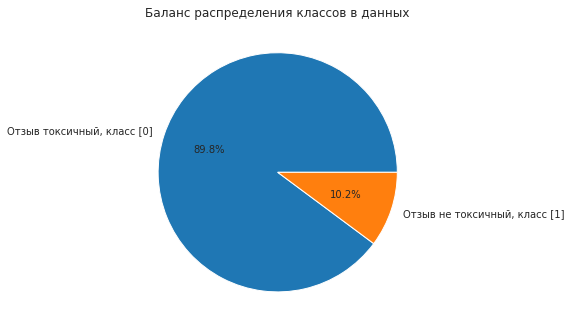

In [ ]:
sns.set_style('darkgrid')
data['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
#plt.xlabel('Класс')
plt.ylabel('')
plt.show()

<a id="step_1.4"></a>
## Разделим выборки

##### Разделим целевые значения и признаки

In [ ]:
X=data.drop('toxic',axis=1)
y=data['toxic']

##### Выполним разделение на тестовые и тренировочные данные

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True,stratify=y)

##### Проверим результат

In [ ]:
train_sample=X_train.shape[0]/X.shape[0]
test_sample=X_test.shape[0]/X.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


<a id="step_1.4.1"></a>
### Проверим распределение класов в *тренировочной* выборке

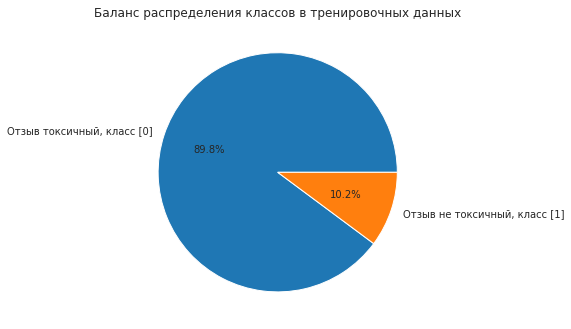

In [ ]:
y_train.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в тренировочных данных')
plt.ylabel('')
plt.show()

<a id="step_1.4.2"></a>
### Проверим распределение класов в *тестовой* выборке

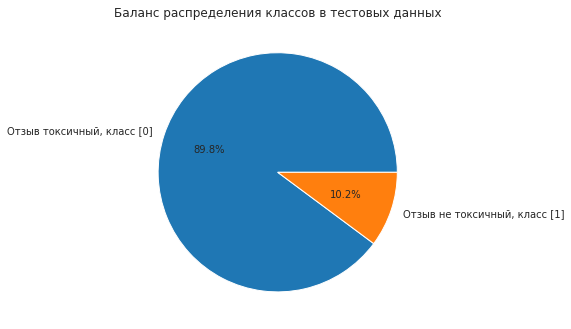

In [ ]:
y_test.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в тестовых данных')
plt.ylabel('')
plt.show()

<a id="step_1.4.3"></a>
### Создадим функцию, для увеличения выборки по первому [1] классу данных и уменьшению выборки по нулевому [0] классу

In [ ]:
def down_up_sample(features, target, fraction, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down_up = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]*repeat)
    target_down_up = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]*repeat)
    
    features_down_up_sampled, target_down_up_sampled = shuffle(
        features_down_up, target_down_up, random_state=12345)
    
    return features_down_up_sampled, target_down_up_sampled

features_upsampled, target_upsampled  = down_up_sample(X_train, y_train, 0.6, 5)

###### Проверим респределение 

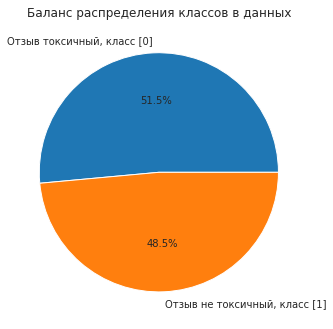

In [ ]:
target_upsampled.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

<a id="step_1.5"></a>
## Используем технологию TF-IDF для обработки наших данны, а так же отфильтруем <br><br>содержимое при помощи библиотеки `nltk`

##### Загрузим библиотеку и стоп-слова из английского языка

In [ ]:
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Создадим корпус из лемматизированных и очищенных слов

In [ ]:
corpus_lemm_train = features_upsampled['lemm_text'].values.astype('U')
corpus_lemm_train.shape

(125350,)

##### Применим модель `TfidfVectorizer` и обучим её на наших тренировочных данных

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words,analyzer='word') 
tf_idf = count_tf_idf.fit_transform(corpus_lemm_train) 
tf_idf.shape

(125350, 102521)

##### Создадим так же корпус слов и для тестовой выборки

In [ ]:
corpus_lemm_test = X_test['lemm_text'].values.astype('U')
corpus_lemm_test.shape

(39893,)

##### Трансформируем тестовую выборку 

In [ ]:
tf_test = count_tf_idf.transform(corpus_lemm_test)
tf_test.shape

(39893, 102521)

<a id="step_1.end"></a>
## Вывод


При ознакомлении с данными мы обнаружили, что они очень сильно разбалансированы в сторону негативного класса. При подготовке данных к обучению мы применили метод `upsampled` *- увеличения выборки с положительным классом* и `downsampled` *- уменьшение с отрицательным*, т.к. при обучении модель может принять за константное предсказание отрицательный класс и очень плохо предсказывать положительный, при этом качество метрики будет высоким, т.к. в тестовых данных так же присутствует сильный дисбаланс

---
---

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_2"></a>
# Обучение


### Создадим функцию для вывода графика плотности распределения предсказанных и истинных значений

In [ ]:
def graph_analis(true, predict):
    f1 = f1_score(y_test, predict)
    plt.figure(figsize=(10,6))
    true.plot(kind='kde', linewidth=2)
    pd.Series(predict).plot(kind='kde',linewidth=2)
    plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
    plt.legend(['Истинные значения','Предсказанные значения'])
    plt.text(0.75,6,'F1= {:.2f}'.format(f1))
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.show()

<a id="step_2.1"></a>
### Создадим функцию для вывода матрицы предсказаний

In [ ]:
def highlight_min(data, color='red'):
    attr = 'color: {}'.format(color)
    if data.ndim == 1:
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
def create_colors(x):
    df1 = x.copy()
    df1.loc[:,:] = 'background-color: '
    df1.loc['Predicted Positive(1)', 'Actually Negative(0)'] = 'background-color: coral'
    df1.loc['Predicted Negative(0)', 'Actually Positive(1)'] = 'background-color: coral' 
    df1.loc['Predicted Positive(1)', 'Actually Positive(1)'] = 'background-color: springgreen'
    df1.loc['Predicted Negative(0)','Actually Negative(0)'] = 'background-color: springgreen'

    return df1      

In [ ]:
def conf_marix(predict):
    table=pd.DataFrame(index=['Predicted Positive(1)','Predicted Negative(0)',], columns=['Actually Positive(1)','Actually Negative(0)','Difference'])
    matrix=confusion_matrix(y_test, predict)
    table['Actually Positive(1)']['Predicted Positive(1)']= 'TP  {:.0f}'.format(matrix[0][0])
    table['Actually Positive(1)']['Predicted Negative(0)']= 'FN   {:.0f}'.format(matrix[1][0])

    table['Actually Negative(0)']['Predicted Positive(1)']= 'FP  {:.0f}'.format(matrix[0][1])
    table['Actually Negative(0)']['Predicted Negative(0)']= 'TN  {:.0f}'.format(matrix[1][1])
    
    table['Difference'][0] = abs(matrix[0][0] - matrix[0][1])
    table['Difference'][1] = abs(matrix[1][1]- matrix[1][0])
    return table.style.apply(create_colors, axis=None).apply(highlight_min, subset=['Difference'])

<a id="step_2.2"></a>
## Обучим модель `DecisionTreeClassifier`

In [ ]:
%%time

best_model_dt = None
best_result_dt = 0
best_depth_dt=0
for depth in tqdm(range(1, 25, 3)):
      
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth,class_weight='balanced') 
    model_dt.fit(tf_idf,target_upsampled) 
    predict_dt=model_dt.predict(tf_test) 
    result_dt = f1_score(y_test, predict_dt)
    if result_dt > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result_dt 
          
        best_depth_dt = depth
print("F1 наилучшей модели равно:", best_result_dt.round(2), end='')
print(' C глубиной:',best_depth_dt)


F1 наилучшей модели равно: 0.61 C глубиной: 22
CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 16s


### Проверим подобранные значения гипрепапарметров модели `DecisionTreeClassifier` и посмотрим на отчёт метрик классификации

In [ ]:
target_names=['Отзыв токсичный','Отзыв не токсичный']

model_dt= DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dt)
model_dt.fit(tf_idf,target_upsampled)
predicted_dt=model_dt.predict(tf_test)

f1_forest_1 = f1_score(y_test, predicted_dt)
print(classification_report(y_test, predicted_dt, target_names=target_names))
print('Метрика F1 качества предсказания модели "DecisionTreeClassifier" равна :',f1_forest_1.round(2))

### Матрица предсказаний модели `DecisionTreeClassifier`

In [ ]:
conf_marix(predicted_dt)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 34916,FP 921,33995
Predicted Negative(0),FN 1879,TN 2177,298


### График распределения плотности предсказанных значений

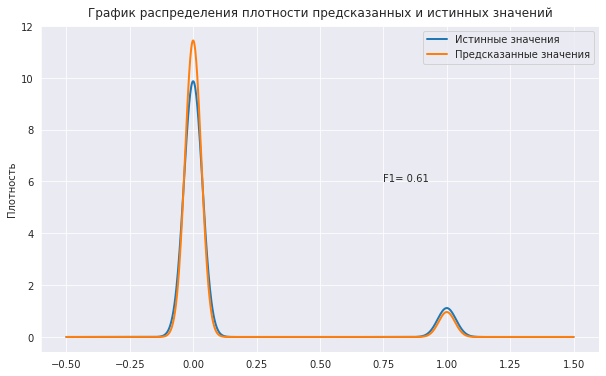

In [ ]:
graph_analis(y_test,predicted_dt)

---

<a id="step_2.3"></a>
## Обучим модель `LogisticRegression` и подберём параметры при помощи <br><br>`GridSearchCV`

In [ ]:
%%time

clf_lr = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 10),
              'max_iter': range (10,15,2),
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(tf_idf, target_upsampled)
grid_lr.best_params_

CPU times: user 1min 18s, sys: 22.4 ms, total: 1min 18s
Wall time: 1min 19s


{'C': 9, 'max_iter': 14}

### Проверим подобранные значения гипрепапарметров наилучшей модели `LogisticRegression` и посмотрим на отчёт метрик классификации

In [ ]:
predicted_lr= grid_lr.predict(tf_test)

f1_log_r_1 = f1_score(y_test, predicted_lr).round(2)
print(classification_report(y_test, predicted_lr, target_names=target_names))
print('Метрика F1 качества предсказания модели "LogisticRegression" равна :',f1_log_r_1)

                    precision    recall  f1-score   support

   Отзыв токсичный       0.98      0.96      0.97     35837
Отзыв не токсичный       0.68      0.83      0.75      4056

          accuracy                           0.94     39893
         macro avg       0.83      0.89      0.86     39893
      weighted avg       0.95      0.94      0.95     39893

Метрика F1 качества предсказания модели "LogisticRegression" равна : 0.75


### Матрица предсказаний модели `LogisticRegression`

In [ ]:
conf_marix(predicted_lr)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 34233,FP 1604,32629
Predicted Negative(0),FN 673,TN 3383,2710


### График распределения плотности предсказанных значений

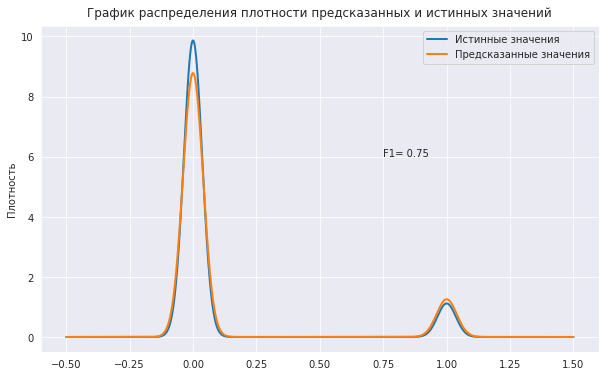

In [ ]:
graph_analis(y_test,predicted_lr)

----

<a id="step_2.4"></a>
## Обучим модель `RandomForestClassifier`

In [ ]:
%%time

best_model_rf = None
best_result_rf = 0
best_depth_rf=0
for est in tqdm(range(1, 12, 4)):
      
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=est,class_weight='balanced_subsample') 
    model_rf.fit(tf_idf,target_upsampled) 
    predict_rf=model_rf.predict(tf_test) 
    result_rf = f1_score(y_test, predict_rf)
    if result_rf > best_result_rf:
        best_model_rf = model_rf
        best_result_rf = result_rf
          
        best_depth_rf = est
print("F1 наилучшей модели равно:", best_result_rf.round(2), end='')
print(' C глубиной:',best_depth_rf)


F1 наилучшей модели равно: 0.69 C глубиной: 9
CPU times: user 1min 39s, sys: 74.3 ms, total: 1min 39s
Wall time: 1min 39s


### Проверим подобранные значения гипрепапарметров модели `RandomForestClassifier` и посмотрим на отчёт метрик классификации

In [ ]:
predict_rfc=model_rf.predict(tf_test)
f1_random_forest = f1_score(y_test, predict_rfc)
print(classification_report(y_test, predict_rfc, target_names=target_names))
print('Метрика F1 качества предсказания модели "RandomForestClassifier" равна :',f1_random_forest.round(2))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.96      0.98      0.97     35837
Отзыв не токсичный       0.78      0.62      0.69      4056

          accuracy                           0.94     39893
         macro avg       0.87      0.80      0.83     39893
      weighted avg       0.94      0.94      0.94     39893

Метрика F1 качества предсказания модели "RandomForestClassifier" равна : 0.69


### Матрица предсказаний модели `RandomForestClassifier`

In [ ]:
conf_marix(predict_rfc)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 35114,FP 723,34391
Predicted Negative(0),FN 1528,TN 2528,1000


### График распределения плотности предсказанных значений

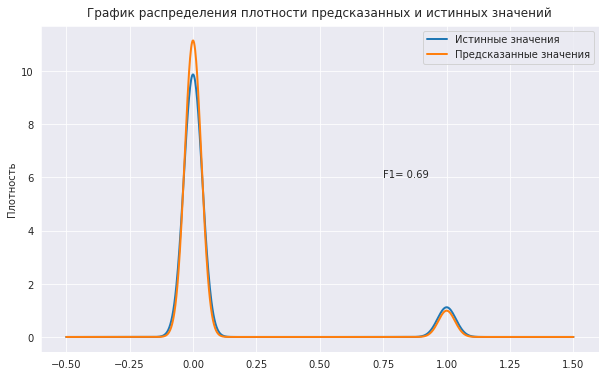

In [ ]:
graph_analis(y_test,predict_rfc)

<a id="step_2.5"></a>
## Определим порог классификации для наилучшей модели `LogisticRegression`

### Для начала определим вероятность возникновения положительного класса

In [ ]:
probabilities=grid_lr.predict_proba(tf_test)
probabilities_one = probabilities[:, 1]
print("Вероятность положительного класса:",probabilities_one[:5])

Вероятность положительного класса: [0.03204474 0.00652658 0.04831519 0.02787483 0.01251171]


### Переберём в цикле значения F1, точности, полноты и выберем порог классификации

In [ ]:
for threshold in np.arange(0.4, 0.9, 0.02):
    predicted_v = probabilities_one > threshold
    precision = precision_score(y_test,predicted_v)
    recall = recall_score(y_test,predicted_v) 
    f1 = f1_score(y_test,predicted_v)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.40 | Точность = 0.625, Полнота = 0.858, F1 = 0.723
Порог = 0.42 | Точность = 0.636, Полнота = 0.854, F1 = 0.729
Порог = 0.44 | Точность = 0.646, Полнота = 0.848, F1 = 0.733
Порог = 0.46 | Точность = 0.657, Полнота = 0.843, F1 = 0.738
Порог = 0.48 | Точность = 0.668, Полнота = 0.839, F1 = 0.744
Порог = 0.50 | Точность = 0.678, Полнота = 0.834, F1 = 0.748
Порог = 0.52 | Точность = 0.690, Полнота = 0.829, F1 = 0.753
Порог = 0.54 | Точность = 0.700, Полнота = 0.822, F1 = 0.756
Порог = 0.56 | Точность = 0.710, Полнота = 0.815, F1 = 0.759
Порог = 0.58 | Точность = 0.719, Полнота = 0.808, F1 = 0.761
Порог = 0.60 | Точность = 0.728, Полнота = 0.803, F1 = 0.764
Порог = 0.62 | Точность = 0.735, Полнота = 0.796, F1 = 0.764
Порог = 0.64 | Точность = 0.743, Полнота = 0.790, F1 = 0.766
Порог = 0.66 | Точность = 0.755, Полнота = 0.782, F1 = 0.768
Порог = 0.68 | Точность = 0.764, Полнота = 0.774, F1 = 0.769
Порог = 0.70 | Точность = 0.777, Полнота = 0.767, F1 = 0.772
Порог = 0.72 | Точность 

### Отобразим на графике кривую зависимости точности предсказания от полноты

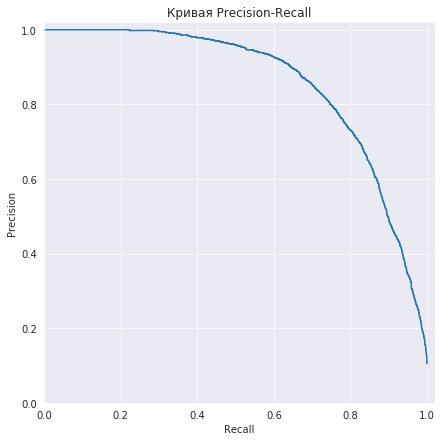

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities[:, 1])
plt.figure(figsize=(7, 7))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.02])
plt.xlim([0.0, 1.02])
plt.title('Кривая Precision-Recall')
plt.show() 

#####  Пороговое значение 0,76 выглидит наиболее оптимальным для нашей модели

In [ ]:
predicted_rf_threshold=(probabilities_one>0.76)*1
print(classification_report(y_test,predicted_rf_threshold, target_names=target_names))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.97      0.98      0.98     35837
Отзыв не токсичный       0.80      0.75      0.77      4056

          accuracy                           0.96     39893
         macro avg       0.89      0.86      0.87     39893
      weighted avg       0.95      0.96      0.95     39893



<a id="step_2.6"></a>
## Проверим выбранный порог для нашей модели

### Выполним предсказания с выбранным порогом

In [ ]:
predicted_test=(grid_lr.predict_proba(tf_test)[:,1] > 0.76)*1
f1_log_r_1 = f1_score(y_test, predicted_test).round(2)
print('Метрика F1 качества предсказания наилучшей модели с порогом классификации 0,76 равна : ',f1_log_r_1)

Метрика F1 качества предсказания наилучшей модели с порогом классификации 0,76 равна :  0.77


### Матрица предсказаний наилучшей модели

In [ ]:
conf_marix(predicted_test)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 35101,FP 736,34365
Predicted Negative(0),FN 1032,TN 3024,1992


### График распределения плотности предсказанных значений наилучшей модели

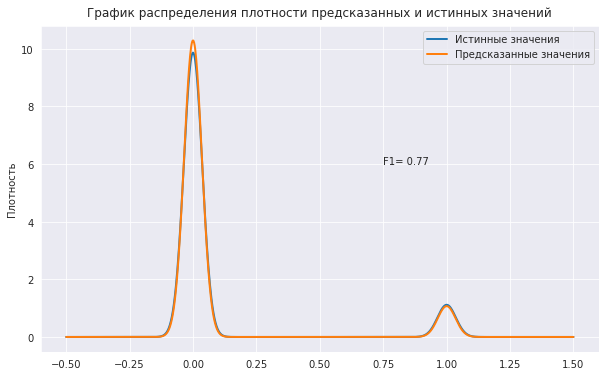

In [ ]:
graph_analis(y_test,predicted_test)

<a id="step_2.7"></a>
## Вычислим ROC-AUC для наилучшей модели

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one)
auc_roc = roc_auc_score(y_test,probabilities_one)
print('ROC-AUC: {:.2f}'.format(auc_roc))

ROC-AUC: 0.96


### Построим график для наглядности распределения значений

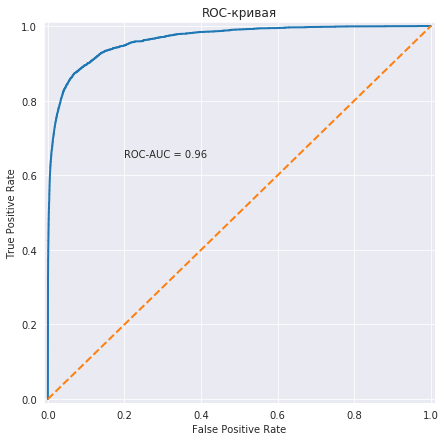

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr,linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.text(0.2,0.65,'ROC-AUC = {:.2f}'.format(auc_roc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

<a id="step_2.end"></a>
## Вывод

### Сведём интересующие нас данные в одну таблицу для наглядности

In [ ]:
comparison_tabl = pd.DataFrame(index=['F1-мера'], columns=['Дерево решений','Cлучайный лес','Логистическая регрессия'])
comparison_tabl['Дерево решений'] = best_result_dt.round(2)
comparison_tabl['Cлучайный лес'] = f1_random_forest.round(2)
comparison_tabl['Логистическая регрессия'] = f1_log_r_1
comparison_tabl.T

,F1-мера
Дерево решений,0.61
Cлучайный лес,0.69
Логистическая регрессия,0.77


Очевидно что модель `LogisticRegression` показала наилучший результат при обучении набрав пороговое значение метрики $F1 = 0.75$ и мы улучшили это значение метрики до $0.77$ подобрав оптимальнй порог в $0.76$

---
---

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_3.end"></a>
# Общий Вывод

   Нашей целью было найти и обучить модель для магазина "**ВИКИШОП**", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы  в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по мерке $F1$ не меньше $0.75$<br>
   
   В нашем распоряжении был набор данных с разметкой о токсичности правок, но для правильной работы предсказательных алгоритмов моделей нам пришлось очистить комментарии от лишних символов и пр.мусора, а так же прибегнуть к балансировке выборок методами `upsample` и `downsamle`, т.к. сильный дисбаланс в классах мог негативно повлиять на качество предсказания моделей. <br>
   
   Для определения наилучшей модели мы остановили наш выбор на трёх моделях `DecisionTreeClassifier`,`LogisticRegression` и  `RandomForestClassifier`. По итогам сравнеиня победила модель `LogisticRegression` и после побора порогового значения, набрала значение метрики $F1=0.77$<br>
   
   Таким образом мы справились с поставленной задачей и для магазина "**ВИКИШОП**" можем смело рекомендовать к использованию в своей работе нашу модель!

---